In [152]:
%load_ext autoreload
%autoreload 2

import torch

import diveslowlearnfast.visualise.lucid_video_pytorch as L

from diveslowlearnfast.models import SlowFast, load_checkpoint, utils as model_utils
from diveslowlearnfast.config import Config
from diveslowlearnfast.train import helper as train_helper
from diveslowlearnfast.visualise.lucid_video_pytorch import SlowFastLucid, NeuronObjective, PadVideo, JitterVideo, RandomRotateVideo, RandomScaleVideo, JitterVideoTemporal

cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 4
cfg.DATA.NUM_FRAMES = 16
device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, *_ = train_helper.get_train_objects(cfg, model, device)
model, *_ = load_checkpoint(model, optimiser, '../misc/run22_best.pth', device)
model.eval()

model = SlowFastLucid(model)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



In [15]:
# Test if our model forwards.
video = L.video(12, 220, batch=1, device='cpu')
video = L.standard_transforms(video).permute(0, 4, 1, 2, 3) # to BCTHW
inputs = model_utils.to_slowfast_inputs(video, alpha=cfg.SLOWFAST.ALPHA)
_ = model(inputs)

param.shape = torch.Size([1, 16, 224, 224, 3])
inp_pathway_0.requires_grad= True
inp_pathway_0.shape= torch.Size([1, 3, 2, 224, 224])
inp_pathway_1.requires_grad= True
inp_pathway_1.shape= torch.Size([1, 3, 16, 224, 224])


  0%|          | 0/41 [00:00<?, ?it/s]

Gradient stats: mean abs: 2.1421614292194135e-05, max: 0.1424197256565094
mean params: 0.5000102519989014
Iteration 0, Loss: 1.2818
Gradient stats: mean abs: 2.1421614292194135e-05, max: 0.1424197256565094
mean params: 0.5001896619796753
Iteration 20, Loss: 14.1800
Gradient stats: mean abs: 2.1421614292194135e-05, max: 0.1424197256565094
mean params: 0.5002793073654175
Iteration 30, Loss: 20.6291


KeyboardInterrupt: 

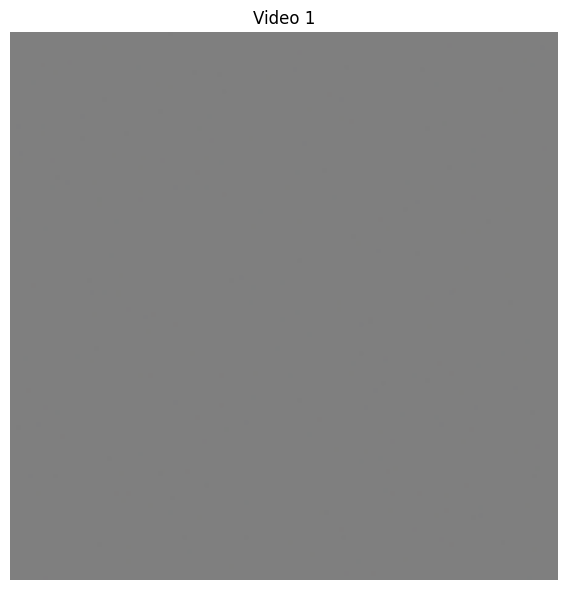

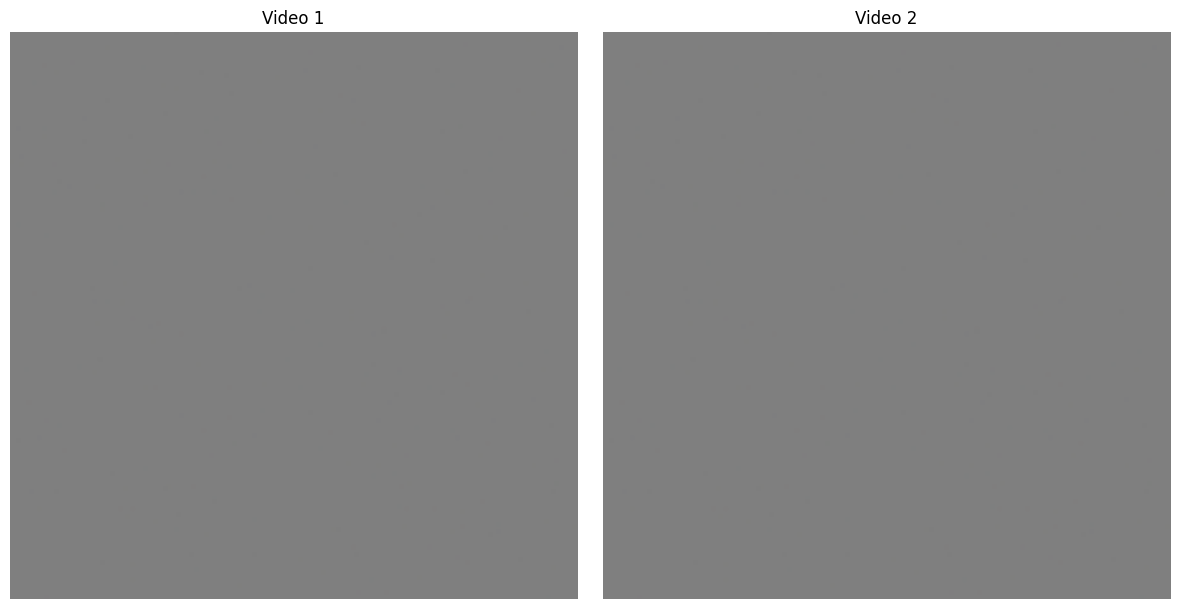

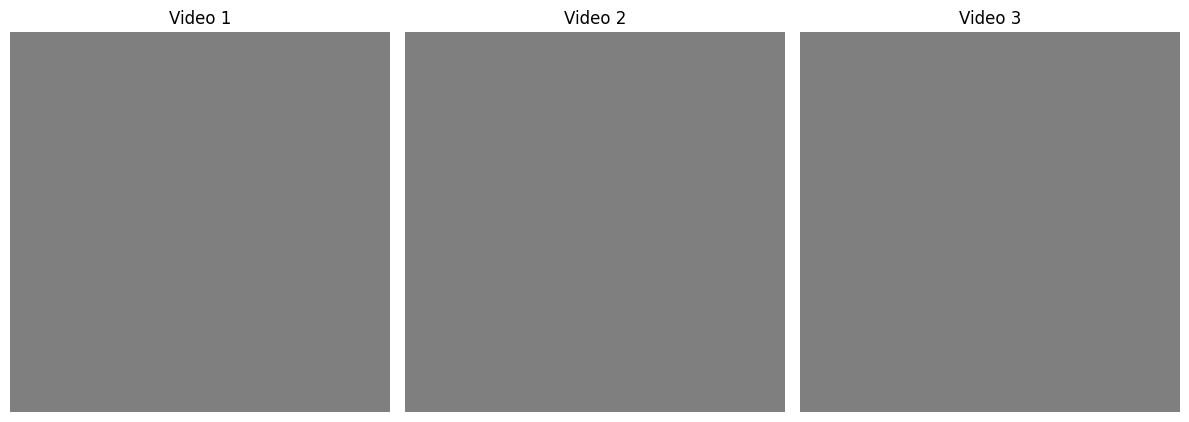

In [156]:
objective = NeuronObjective('slow_stem', 24)

# Create parameterization function
# Create a normal distributed rgb video of 12 frames by 220 x 220 pixels
# I chose this particular resolution with the idea that the L.standard_transform
# will turn this param_f into our desired 16x224x224
param_f = lambda: L.video(16, 224, batch=1, device='cpu', fft=False)

videos = L.render_vis(
    model,
    objective,
    cfg,
    param_f=param_f,
    transforms=None, #L.standard_transforms,
    thresholds=[0, 20, 30, 40],
    verbose=True,
    device='cpu',
)

# L.display_videos([videos[-1]])

In [149]:
videos[0].mean()

tensor(0.5004)

## Understanding the `L.standard_transform`
Our inputs need adhere to the desired ratios in the SlowFast network. The SlowFast network is very particular about input dimension due to concatenating on several occasions during the forward pass. See the code below for how the input shape develops through the standard transform.

In [31]:
transform = L.ComposeTransforms([
    PadVideo(12, mode='constant', value=0.5),
    JitterVideoTemporal(8),
    RandomScaleVideo([1 + (i - 5) / 50. for i in range(11)]),
    RandomRotateVideo(list(range(-10, 11)) + 5 * [0]),
    JitterVideoTemporal(4),
])
v = L.video(12, 220, 220, device='cpu')
o1 = PadVideo(8, mode='constant', value=0.5)(v) # + 16
o2 = JitterVideoTemporal(8)(o1) # -8
o3 = RandomScaleVideo([1 + (i - 5) / 50. for i in range(11)])(o2)
o4 = RandomRotateVideo(list(range(-10, 11)) + 5 * [0])(o3)
o5 = JitterVideoTemporal(4)(o4) # -4
v.shape, o1.shape, o2.shape, o5.shape

(torch.Size([1, 12, 220, 220, 3]),
 torch.Size([1, 28, 236, 236, 3]),
 torch.Size([1, 20, 228, 228, 3]),
 torch.Size([1, 16, 224, 224, 3]))

In [112]:
video = L.video(16, 224, 224, device='cpu')
inputs = model_utils.to_slowfast_inputs(video.permute(0, 4, 1, 2, 3), alpha=cfg.SLOWFAST.ALPHA, requires_grad=True)
optimiser = torch.optim.Adam([inputs[0]], lr=1)

inputs[0].requires_grad

True

In [132]:
optimiser.zero_grad()
_ = model(inputs)

In [133]:
loss = objective(model, inputs)
loss

tensor(6.0893, grad_fn=<SelectBackward0>)

In [134]:
loss.backward()

In [135]:
inputs[0].grad.sum()

tensor(-0.4460)

In [136]:
optimiser.step()

In [141]:
optimiser.param_groups[0]['params'][0].shape

torch.Size([1, 3, 2, 224, 224])